<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/Results_Arr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! wget -r -N -c -np https://physionet.org/files/afdb/1.0.0/
! wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install wfdb

In [4]:
def evaluation(peaks, real_peaks, interval):
    check_peaks = peaks.copy()
    n_ref = len(real_peaks[1:])
    n_detected = len(peaks)
    count = 0
    for i in range(n_ref):
        correct = real_peaks[1:][i]
        condition = (check_peaks>=correct-interval) & (check_peaks<=correct+interval)
        found = np.array(check_peaks)[condition]
        if len(found) >= 1:
          for f in found:
            check_peaks.remove(f)
          count += 1
    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": str(sensitivity*100)+'%',
              'PPV': str(ppv*100)+'%',
              'F1': str(f1*100) + '%'
              }
    return result

## Import and Functions

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import wfdb

In [7]:
def get_ids(file_path, d):
  arr = os.listdir(file_path)

  sample_ids = []
  for file in arr:
      if '.atr' in file:
        current_id = int(file[:d])
        if current_id not in sample_ids:
          sample_ids.append(current_id)
  sample_ids.sort()

  return sample_ids

## About the Dataset

### AF Database

In [8]:
rootpath = '/content/physionet.org/files/afdb/1.0.0/'

In [9]:
sample_ids = get_ids(rootpath, 5)
sample_ids.remove(int('03665'))
sample_ids.remove(int('00735'))
sample_ids.remove(int('04043'))

In [10]:
df = pd.DataFrame(columns=['Beats', 'AFs'], index = sample_ids)


In [11]:
for id in sample_ids:
  str_id = '0'*(5-len(str(id)))+str(id)
  # print(str_id)
  # for lead in ['ECG1', 'ECG2']:
  annots = wfdb.rdann(rootpath+str_id, 'atr', 0, None)
  annots_org = wfdb.rdann(rootpath+str_id, 'qrs', 0, None)
  df.loc[id, 'Beats'] = len(annots_org.sample)
  df.loc[id, 'AFs'] =len(annots.sample)
  
df

,Beats,AFs
4015,44005,15
4048,39934,15
4126,42860,15
4746,47873,11
4908,61760,17
4936,53646,73
5091,36793,17
5121,49881,42
5261,45534,23
6426,55155,55


In [12]:
np.sum(df['AFs']), np.sum(df['Beats'])

(439, 1066646)

In [13]:
(np.sum(df['AFs'])/np.sum(df['Beats']))*100

0.04115704741779372

### Arrthymia Database

In [14]:
rootpath = '/content/physionet.org/files/mitdb/1.0.0/'

ids = get_ids(rootpath, 3)
df = pd.DataFrame(columns=['Beats', 'AFs'], index = ids)

for id in ids:
  str_id = str(id)

  annots = wfdb.rdann(rootpath+str_id, 'atr', 0, None)
  af_idx = []
  for i in range(len(annots.sample)):
    if annots.symbol[i] != 'N':
      af_idx.append(annots.sample[i])
  
  df.loc[id, 'Beats'] = len(annots.sample)
  df.loc[id, 'AFs'] =len(af_idx)

In [15]:
df

,Beats,AFs
100,2274,35
101,1874,14
102,2192,2093
103,2091,9
104,2311,2148
105,2691,165
106,2098,591
107,2140,2140
108,1824,85
109,2535,2535


In [ ]:
np.sum(df['AFs']), np.sum(df['Beats'])

(37595, 112647)

In [16]:
(np.sum(df['AFs'])/ np.sum(df['Beats']))*100

33.37416886379575

# Beat Detection Results on NSR

In [18]:
labels = ['Sensitivity', 'PPV', 'F1']
def plot_lead(dfs, lead):
  plt.figure(figsize=(15,5))
  for i in range(0, len(dfs)):
    df = dfs[i]
    plt.plot([str(int(a)) for a in df.index], df[lead], marker = 'o', linestyle = '-', label = labels[i])
    print(labels[i], np.mean(df[lead]))
  plt.legend()

## Pan-Tompkins 

### My Implementation - Move Up

In [20]:
df_sen = pd.read_csv("/content/gdrive/My Drive/4peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/4peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/4peaks/f1.csv" )

a = df_sen.drop(list(range(0,13)))
b = df_ppv.drop(list(range(0,13)))
c = df_f1.drop(list(range(0,13)))

a= a.set_index('Unnamed: 0')
b= b.set_index('Unnamed: 0')
c= c.set_index('Unnamed: 0')

In [21]:
dfs = []
for a in [a, b, c]:
  first_5 = a.iloc[list(range(0,5))]
  rest = a.drop(a.index[0:5])
  rest = rest.drop(columns=['Unnamed: 0.1'])
  partb = first_5.set_index('Unnamed: 0.1')
  partb.index.name = 'ID'
  rest.index.name = 'ID'
  new_df = rest.append(partb)
  dfs.append(new_df)

Sensitivity 91.69115721628832
PPV 96.96492526799436
F1 93.12618559188243


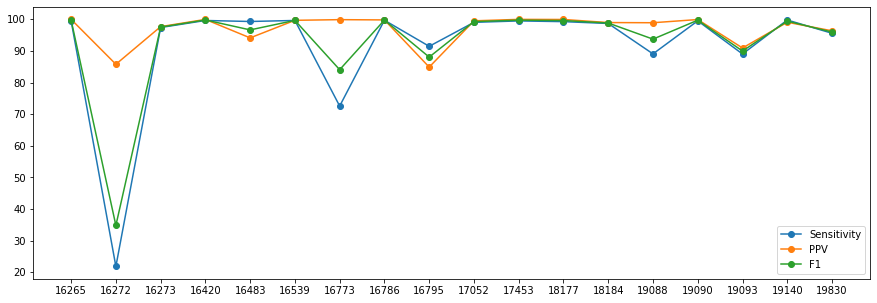

In [22]:
plot_lead(dfs, 'ECG1')

Sensitivity 80.58599921769661
PPV 90.02814507762479
F1 82.47657437345318


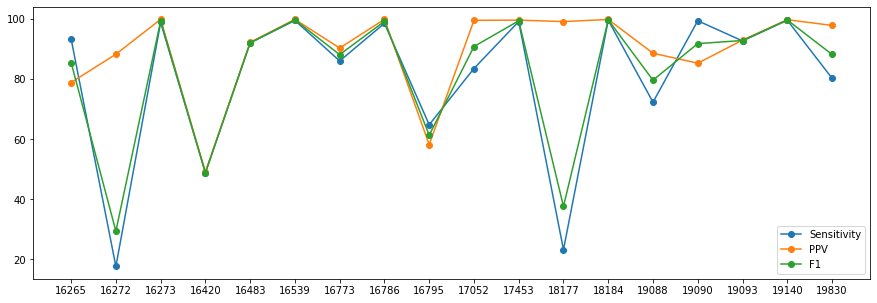

In [23]:
plot_lead(dfs, 'ECG2')

### Neurokit2

In [24]:
df_sen = pd.read_csv("/content/gdrive/My Drive/2peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/2peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/2peaks/f1.csv" )

In [26]:
dfs = []
for df in [df_sen, df_ppv, df_f1]:
  a = df.drop(list(range(10,15))).set_index(['Unnamed: 0'])
  first_5 = a.iloc[list(range(0,10))+[10, 11, 12]]
  parta = first_5.set_index('Unnamed: 0.1')
  rest = a.drop(list(range(0,10))+[15, 16, 17])
  partb = rest.drop(columns=['Unnamed: 0.1'])
  parta.index.name = 'ID'
  partb.index.name = 'ID'
  new_df = parta.append(partb)
  dfs.append(new_df.sort_index())

Sensitivity 92.40301331399206
PPV 99.71357721991279
F1 94.62835456027821


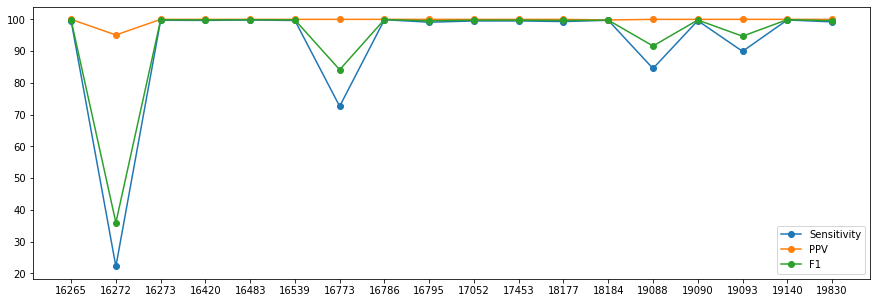

In [27]:
plot_lead(dfs, 'ECG1')

Sensitivity 91.70034828436637
PPV 99.86494170620901
F1 94.1523959953412


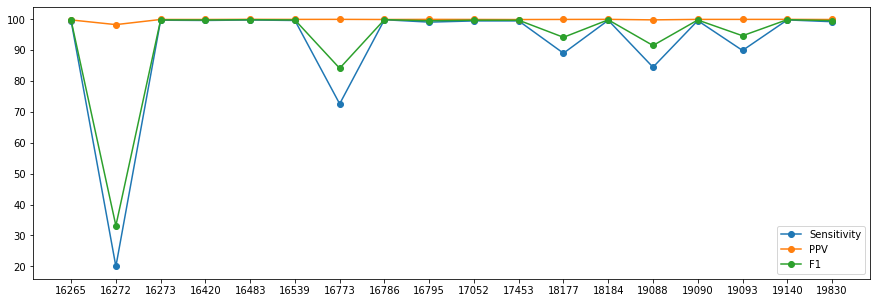

In [28]:
plot_lead(dfs, 'ECG2')

## Hamilton-Tompkins

### My Implementation

In [30]:
df_sen = pd.read_csv("/content/gdrive/My Drive/0peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/0peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/0peaks/f1.csv" )

In [31]:
df_sen1 = pd.read_csv("/content/gdrive/MyDrive/0peaks/ppv2 (1).csv" )
df_ppv1 = pd.read_csv("/content/gdrive/MyDrive/0peaks/ppv2 (1).csv" )
df_f11 = pd.read_csv("/content/gdrive/MyDrive/0peaks/ppv2 (1).csv" )

In [32]:
dfs = [df_sen.set_index('Unnamed: 0'), 
       df_ppv.set_index('Unnamed: 0'), 
       df_f1.set_index('Unnamed: 0')]
dfs1 = [df_sen1.set_index('Unnamed: 0'), 
        df_ppv1.set_index('Unnamed: 0'), 
        df_f11.set_index('Unnamed: 0')]
for id in [18184, 19088, 19090]:
  for lead in ['ECG1', 'ECG2']:
    for i in range(3):
      dfs[i].at[id, lead] = dfs1[i].at[id, lead]


Sensitivity 87.25643038236447
PPV 64.98453257052695
F1 74.04169505288203


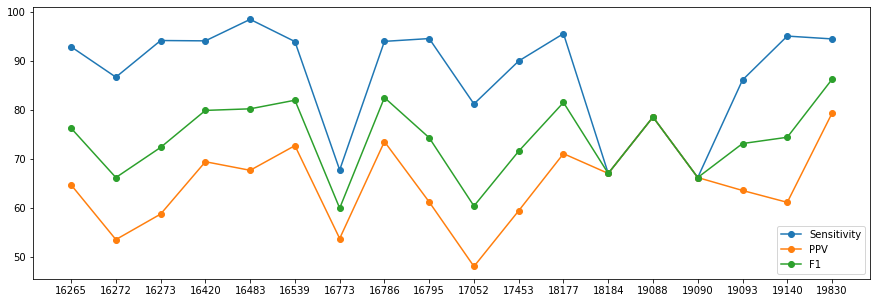

In [35]:
plot_lead(dfs, 'ECG1')

Sensitivity 84.60679270308346
PPV 59.50219704007933
F1 69.26192981383636


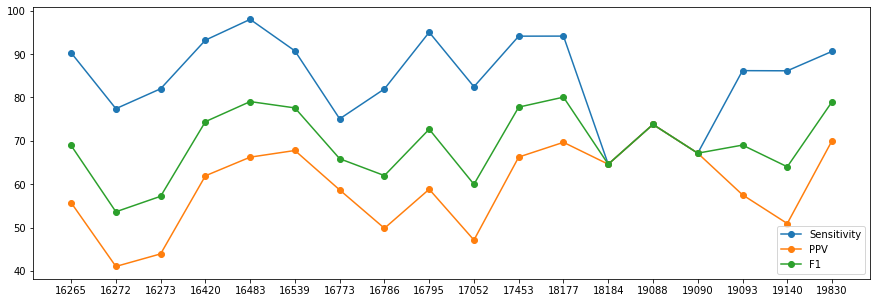

In [36]:
plot_lead(dfs, 'ECG2')

### Neurokit2

In [37]:
df_sen = pd.read_csv("/content/gdrive/My Drive/3peaks/sen.csv" )
df_ppv = pd.read_csv("/content/gdrive/My Drive/3peaks/ppv.csv" )
df_f1 = pd.read_csv("/content/gdrive/My Drive/3peaks/f1.csv" )

In [38]:
df_sen = df_sen.set_index('Unnamed: 0')
df_ppv = df_ppv.set_index('Unnamed: 0')
df_f1 = df_f1.set_index('Unnamed: 0')

In [40]:
# for id in [16420]:

#   for lead in ['ECG1']:
#     model_save_name = str(id)+'-'+lead+'.npz'
#     path = F"/content/gdrive/My Drive/3peaks/{model_save_name}" 
#     saved = np.load(path, allow_pickle=True)
#     peaks = list(saved['detected'])
#     real_peaks = list(saved['ref'])
#     res = evaluation(peaks, real_peaks, int(150/(1000/128)))
#     df_sen.loc[id, lead] = float(res['sensitivity'][0:-1])
#     df_ppv.loc[id, lead] = float(res['PPV'][0:-1])
#     df_f1.loc[id, lead] = float(res['F1'][0:-1])

#     df_sen.to_csv("/content/gdrive/My Drive/3peaks/sen.csv" )
#     df_ppv.to_csv("/content/gdrive/My Drive/3peaks/ppv.csv" )
#     df_f1.to_csv("/content/gdrive/My Drive/3peaks/f1.csv" )

In [41]:
dfs = []
for df in [df_sen, df_ppv, df_f1]:
  a = df.drop(list(range(4,18)))
  first_5 = a.iloc[list(range(0,4))]
  rest = a.drop(a.index[0:4])
  rest = rest.drop(columns=['Unnamed: 0.1'])
  partb = first_5.set_index('Unnamed: 0.1')
  partb.index.name = 'ID'
  rest.index.name = 'ID'
  new_df = rest.append(partb)
  dfs.append(new_df.sort_index().drop_duplicates())

Sensitivity 96.41594329780112
PPV 99.88990443199499
F1 97.97898172759305


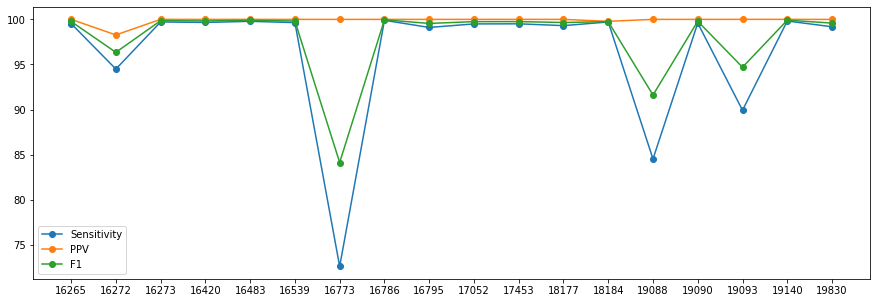

In [42]:
plot_lead(dfs, 'ECG1')

Sensitivity 96.18206087539414
PPV 99.88272642156518
F1 97.85259578307159


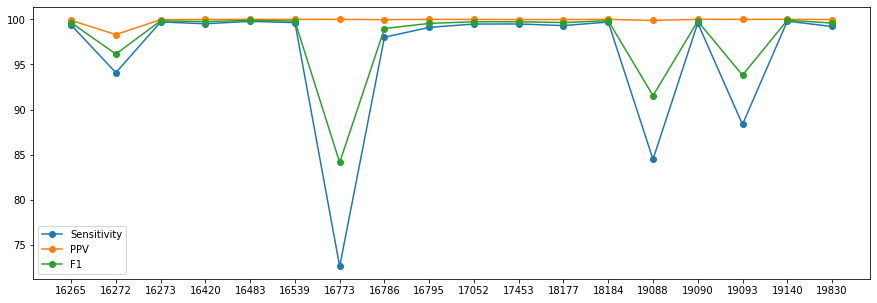

In [43]:
plot_lead(dfs, 'ECG2')

# Beat Detection Results on Arrthymia Database

In [44]:
def get_results(dfs):
  label = ['Sensitivity', 'PPV', 'F1']
  for i in range(3):
    a = dfs[i]
    dict_res = {}
    array_res = []
    df = a.set_index('Unnamed: 0')
    for col in df.columns:
      if col == 'ECG1' or col == 'ECG2':
        continue
      else:
        res = []
        for item in df[col]:
          if np.isnan(item):
            continue
          else:
            res.append(item)
            array_res.append(item)
        dict_res[col] = (np.mean(res), len(res))
    print(label[i], np.mean(array_res))
    print(dict_res)

## Pan-Tompkins

In [ ]:
df_sen=pd.read_csv("/content/gdrive/My Drive/0arr/pt/sen.csv" )
df_ppv=pd.read_csv("/content/gdrive/My Drive/0arr/pt/ppv.csv" )
df_f1=pd.read_csv("/content/gdrive/My Drive/0arr/pt/f1.csv" )

dfs = [df_sen, df_ppv, df_f1]

In [ ]:
get_results(dfs)

Sensitivity 84.41233233294653
{'MLII': (94.04674890150429, 46), 'V5': (90.41569924955381, 5), 'V1': (74.33236471295737, 40), 'V2': (64.27045066827657, 4), 'V4': (94.97856705450091, 1)}
PPV 91.1102230637802
{'MLII': (96.04268667579422, 46), 'V5': (93.03532820788858, 5), 'V1': (88.54393881269017, 40), 'V2': (55.95718597485219, 4), 'V4': (97.85488958990535, 1)}
F1 85.76679693206025
{'MLII': (94.03820893019966, 46), 'V5': (91.65807794524878, 5), 'V1': (78.03671097953911, 40), 'V2': (57.92519730287326, 4), 'V4': (96.39527656929768, 1)}


### Neurokit Implementation

In [ ]:
df_sen=pd.read_csv("/content/gdrive/My Drive/0arr/pt2/sen.csv" )
df_ppv=pd.read_csv("/content/gdrive/My Drive/0arr/pt2/ppv.csv" )
df_f1=pd.read_csv("/content/gdrive/My Drive/0arr/pt2/f1.csv" )

In [ ]:
dfs = [df_sen, df_ppv, df_f1]

In [ ]:
get_results(dfs)

Sensitivity 90.49230688011035
{'MLII': (95.17841865930141, 46), 'V5': (88.50502380367442, 5), 'V1': (84.78717106158754, 40), 'V2': (94.14329133983983, 4), 'V4': (98.4690753214942, 1)}
PPV 94.46971976426234
{'MLII': (97.65631748599638, 46), 'V5': (89.06377206776911, 5), 'V1': (91.3984801577992, 40), 'V2': (94.05025315835239, 4), 'V4': (99.443413729128, 1)}
F1 92.04288798973892
{'MLII': (96.35793375352928, 46), 'V5': (88.78173325998537, 5), 'V1': (87.11023835102353, 40), 'V2': (94.09506196446874, 4), 'V4': (98.95384615384616, 1)}


## Hamilton-Tompkins

### My Implementation

In [ ]:
df_sen=pd.read_csv("/content/gdrive/My Drive/0arr/hm/sen.csv" )
df_ppv=pd.read_csv("/content/gdrive/My Drive/0arr/hm/ppv.csv" )
df_f1=pd.read_csv("/content/gdrive/My Drive/0arr/hm/f1.csv" )

dfs = [df_sen, df_ppv, df_f1]

In [ ]:
get_results(dfs)

Sensitivity 62.21313339658388
{'MLII': (63.443083300628764, 46), 'V5': (47.78028597573215, 5), 'V1': (63.31880401769028, 40), 'V2': (59.49183274826205, 4), 'V4': (44.45805266380894, 1)}
PPV 30.197275451244327
{'MLII': (31.624428189127837, 46), 'V5': (18.555143255253885, 5), 'V1': (30.800815991765273, 40), 'V2': (26.296956070053714, 4), 'V4': (14.218566392479437, 1)}
F1 40.151852059089855
{'MLII': (41.6094179063836, 46), 'V5': (26.50061423804424, 5), 'V1': (41.0303208953557, 40), 'V2': (36.320610874809674, 4), 'V4': (21.546223475293065, 1)}


### Neurokit Implementation

In [ ]:
df_sen=pd.read_csv("/content/gdrive/My Drive/0arr/hm2/sen.csv" )
df_ppv=pd.read_csv("/content/gdrive/My Drive/0arr/hm2/ppv.csv" )
df_f1=pd.read_csv("/content/gdrive/My Drive/0arr/hm2/f1.csv" )

dfs = [df_sen, df_ppv, df_f1]

In [ ]:
get_results(dfs)

Sensitivity 90.09533549538793
{'MLII': (89.86857260357485, 46), 'V5': (98.95774429541108, 5), 'V1': (89.6671717292792, 40), 'V2': (83.85922819612546, 4), 'V4': (98.28536436007349, 1)}
PPV 93.26405852269511
{'MLII': (92.92450881988408, 46), 'V5': (99.50076705592873, 5), 'V1': (93.77915057598638, 40), 'V2': (82.69288729785075, 4), 'V4': (99.38080495356036, 1)}
F1 91.49951335766382
{'MLII': (91.27117055851123, 46), 'V5': (99.22703695780311, 5), 'V1': (91.4413384601195, 40), 'V2': (83.21516604733281, 4), 'V4': (98.83004926108376, 1)}


# Why Failed

## Pan-Tompkins

In [46]:
from scipy import signal, ndimage

In [61]:
def get_data(datapath, leads, start_samp, end_samp):
    signal, fields = wfdb.rdsamp(datapath, sampfrom=start_samp, sampto=end_samp, 
                                channel_names = leads)
    annots = wfdb.rdann(datapath, 'atr', sampfrom=start_samp, sampto=end_samp)

    return signal, annots.sample

def np_mark_peaks(plt, samples, peaks, title):
    plt.plot(samples)
    for peak in peaks:
        plt.axvline(x = peak, color = 'r')
    plt.title.set_text(title)

In [48]:
def pan_tompkins(input_signal, sampling_frequency, low, high):
    filtered_singal = bandpass_filter(input_signal, low, high,sampling_frequency)
    moving_avg = moving_window_integration(squaring(derivative(filtered_singal, sampling_frequency
                                            )), int(0.15*sampling_frequency))
    moving_avg[: int(0.2 * sampling_frequency)] = 0
    peaks = detect_peaks(moving_avg, sampling_frequency)

    return peaks

def detect_peaks(detection, sampling_rate=1000, **kwargs):
    """Based on https://github.com/berndporr/py-ecg-detectors/
    Optimized for vectorized computation.
    """
    min_peak_distance = int(0.3 * sampling_rate)
    min_missed_distance = int(0.25 * sampling_rate)

    signal_peaks = []

    SPKI = 0.0
    NPKI = 0.0

    last_peak = 0
    last_index = -1

    peaks, _ = signal.find_peaks(detection, plateau_size=(1, 1))
    for index, peak in enumerate(peaks):
        peak_value = detection[peak]

        threshold_I1 = NPKI + 0.25 * (SPKI - NPKI)
        if peak_value > threshold_I1 and peak > last_peak + min_peak_distance:
            signal_peaks.append(peak)

            # RR_missed threshold is based on the previous eight R-R intervals
            if len(signal_peaks) > 9:
                RR_ave = (signal_peaks[-2] - signal_peaks[-10]) // 8
                RR_missed = int(1.66 * RR_ave)
                if peak - last_peak > RR_missed:
                    missed_peaks = peaks[last_index + 1 : index]
                    missed_peaks = missed_peaks[
                        (missed_peaks > last_peak + min_missed_distance)
                        & (missed_peaks < peak - min_missed_distance)
                    ]
                    threshold_I2 = 0.5 * threshold_I1
                    missed_peaks = missed_peaks[detection[missed_peaks] > threshold_I2]
                    if len(missed_peaks) > 0:
                        signal_peaks[-1] = missed_peaks[np.argmax(detection[missed_peaks])]
                        signal_peaks.append(peak)

            last_peak = peak
            last_index = index

            SPKI = 0.125 * peak_value + 0.875 * SPKI
        else:
            NPKI = 0.125 * peak_value + 0.875 * NPKI

    return signal_peaks

def moving_window_integration(signal, window_size):
    window_size = int(window_size)

    mwa = ndimage.uniform_filter1d(signal, window_size, origin=(window_size - 1) // 2)

    head_size = min(window_size - 1, len(signal))
    mwa[:head_size] = np.cumsum(signal[:head_size]) / np.linspace(1, head_size, head_size)
    return mwa

def squaring(input_signal):
    return np.square(input_signal)

def derivative(input_signal, sampled_frequency):
    return derivative_difference_equation(input_signal, sampled_frequency)

def bandpass_filter(input_signal, low, high, sampling_freq):
    return highpass_filter(lowpass_filter(input_signal, high, sampling_freq), low, sampling_freq)

def lowpass_filter(input_signal, cutoff, sampling_freq):
    return low_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def highpass_filter(input_signal, cutoff, sampling_freq):
    return high_pass_scipy_butterworth(input_signal, cutoff, sampling_freq)

def derivative_numpy(input_signal, sampling_frequency):
    return np.diff(input_signal)

# y(n) = (1/8)*T 
#        *[-x(n-2) -2*x(n-1) +2x(n+1) +x(n+2)]
def derivative_difference_equation(input_signal, sampled_frequency):
    derived_signal = input_signal.copy()
    for index in range(len(input_signal)):
        derived_sample = derived_signal[index]
        if (index >= 2): derived_sample -= input_signal[index-2]
        if (index >= 1): derived_sample -= 2*input_signal[index-1]
        
        if (index < len(input_signal)-1): derived_sample += 2*input_signal[index+1]
        if (index < len(input_signal)-2): derived_sample += input_signal[index+2]
    
    derived_signal = derived_signal / ((1/8)*(1/sampled_frequency))
    return derived_signal

def low_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(2, cutoff_freq/(sampling_freq/2), 'low', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

def high_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(1, cutoff_freq/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

In [67]:
def run_pantompkins(path, lead, low_cutoff, high_cutoff, sampling_freq, start, signal_length):
    
    example_path = path
    leads = [lead]

    raw_samples, real_peaks= get_data(example_path, leads, start, signal_length)
    raw_samples = raw_samples.squeeze()
    
    pre_low = raw_samples - np.mean(raw_samples)

    low_pass = lowpass_filter(pre_low, high_cutoff, sampling_freq)
    high_pass = highpass_filter(low_pass, low_cutoff, sampling_freq)

    derived = derivative(high_pass, sampling_freq)
    squared = squaring(derived)

    mvg = moving_window_integration(squared, int(0.15*sampling_freq))

    peaks = pan_tompkins(pre_low, sampling_freq, low_cutoff, high_cutoff)
    fig, axs = plt.subplots(8, figsize=(15, 40))
    axs[0].plot(raw_samples)
    axs[0].title.set_text('a) Raw')
    axs[1].plot(pre_low)
    axs[1].title.set_text('b) Shifted')
    axs[2].plot(high_pass)
    axs[2].title.set_text('c) Bandpass')
    axs[3].plot(derived)
    axs[3].title.set_text('d) Derivative')
    axs[4].plot(squared)
    axs[4].title.set_text('e) Squaring')
    axs[5].plot(mvg)
    axs[5].title.set_text('f) Moving Average')
    # shift_back = []
    # for peak in peaks:
    #   shift_back.append(peak+100)
    np_mark_peaks(axs[6], pre_low, peaks, 'g) Peaks')
    np_mark_peaks(axs[7], pre_low, real_peaks-start, 'h) Annotations')

    # real_predicted = [i for i in real_peaks if i>100]
    return peaks, real_peaks

## Test

Clean Signal


{'sensitivity': '9.090909090909092%',
 'PPV': '8.333333333333332%',
 'F1': '8.695652173913043%'}

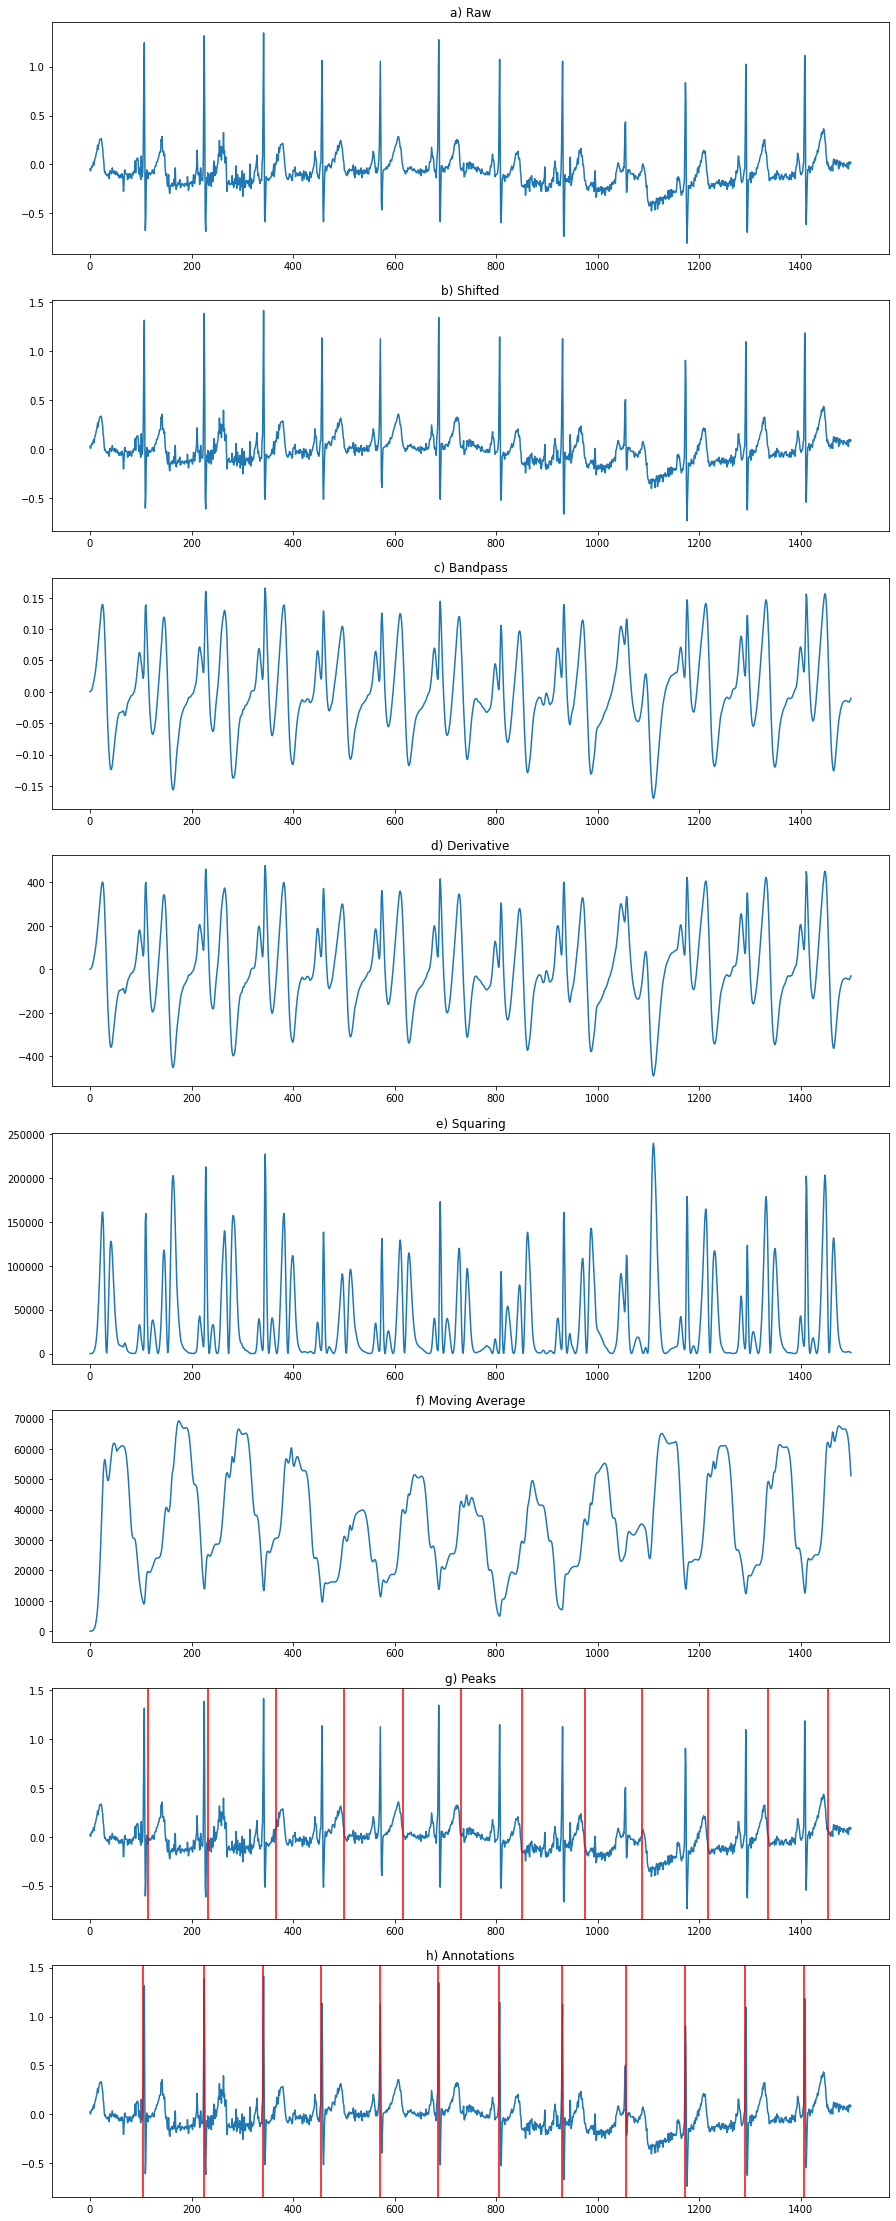

In [69]:
spath = '/content/physionet.org/files/nsrdb/1.0.0/16272'
print('Clean Signal')
peaks, real_peaks = run_pantompkins(spath, 'ECG1', 5, 11, 360, 11000, 12500)
evaluation(peaks, real_peaks-11000, int(150/(1000/128)))

Clean Signal


{'sensitivity': '27.27272727272727%',
 'PPV': '27.27272727272727%',
 'F1': '27.27272727272727%'}

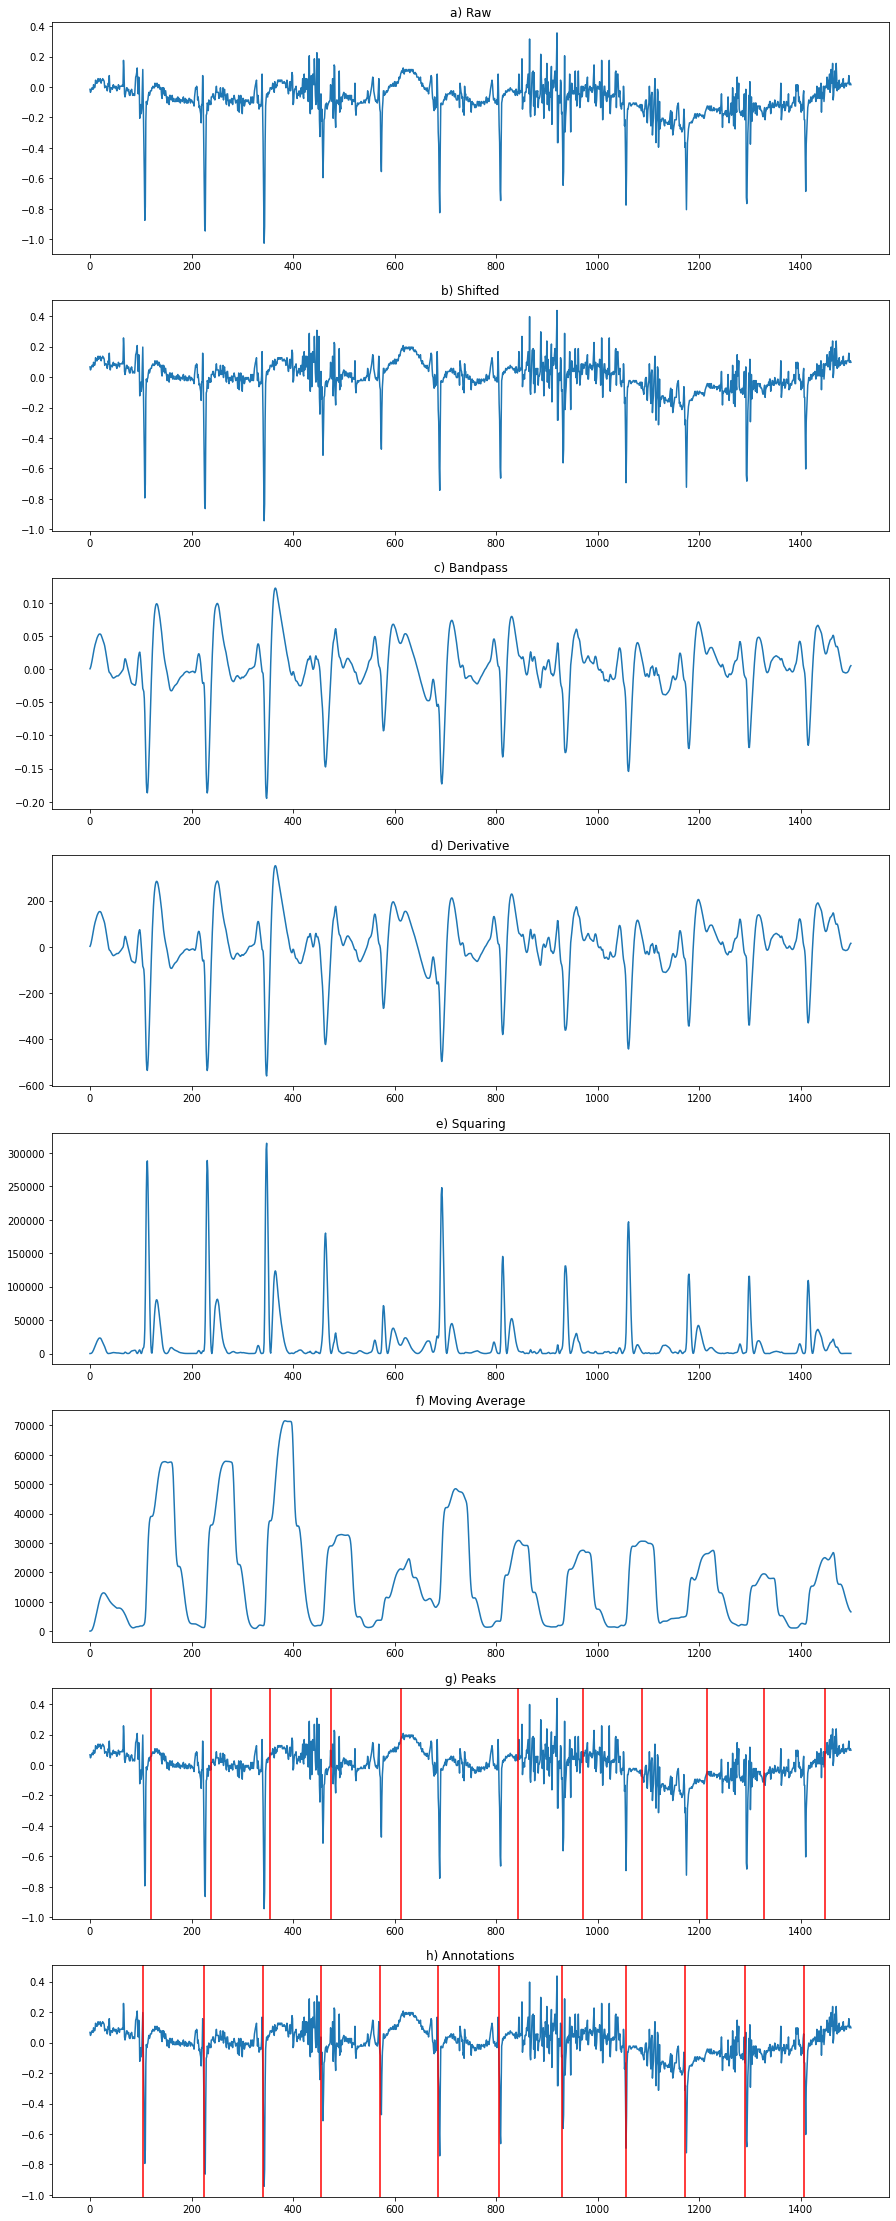

In [70]:
spath = '/content/physionet.org/files/nsrdb/1.0.0/16272'
print('Clean Signal')
peaks, real_peaks = run_pantompkins(spath, 'ECG2', 5, 11, 360, 11000, 12500)
evaluation(peaks, real_peaks-11000, int(150/(1000/128)))

Clean Signal


{'sensitivity': '32.142857142857146%',
 'PPV': '81.81818181818183%',
 'F1': '46.15384615384615%'}

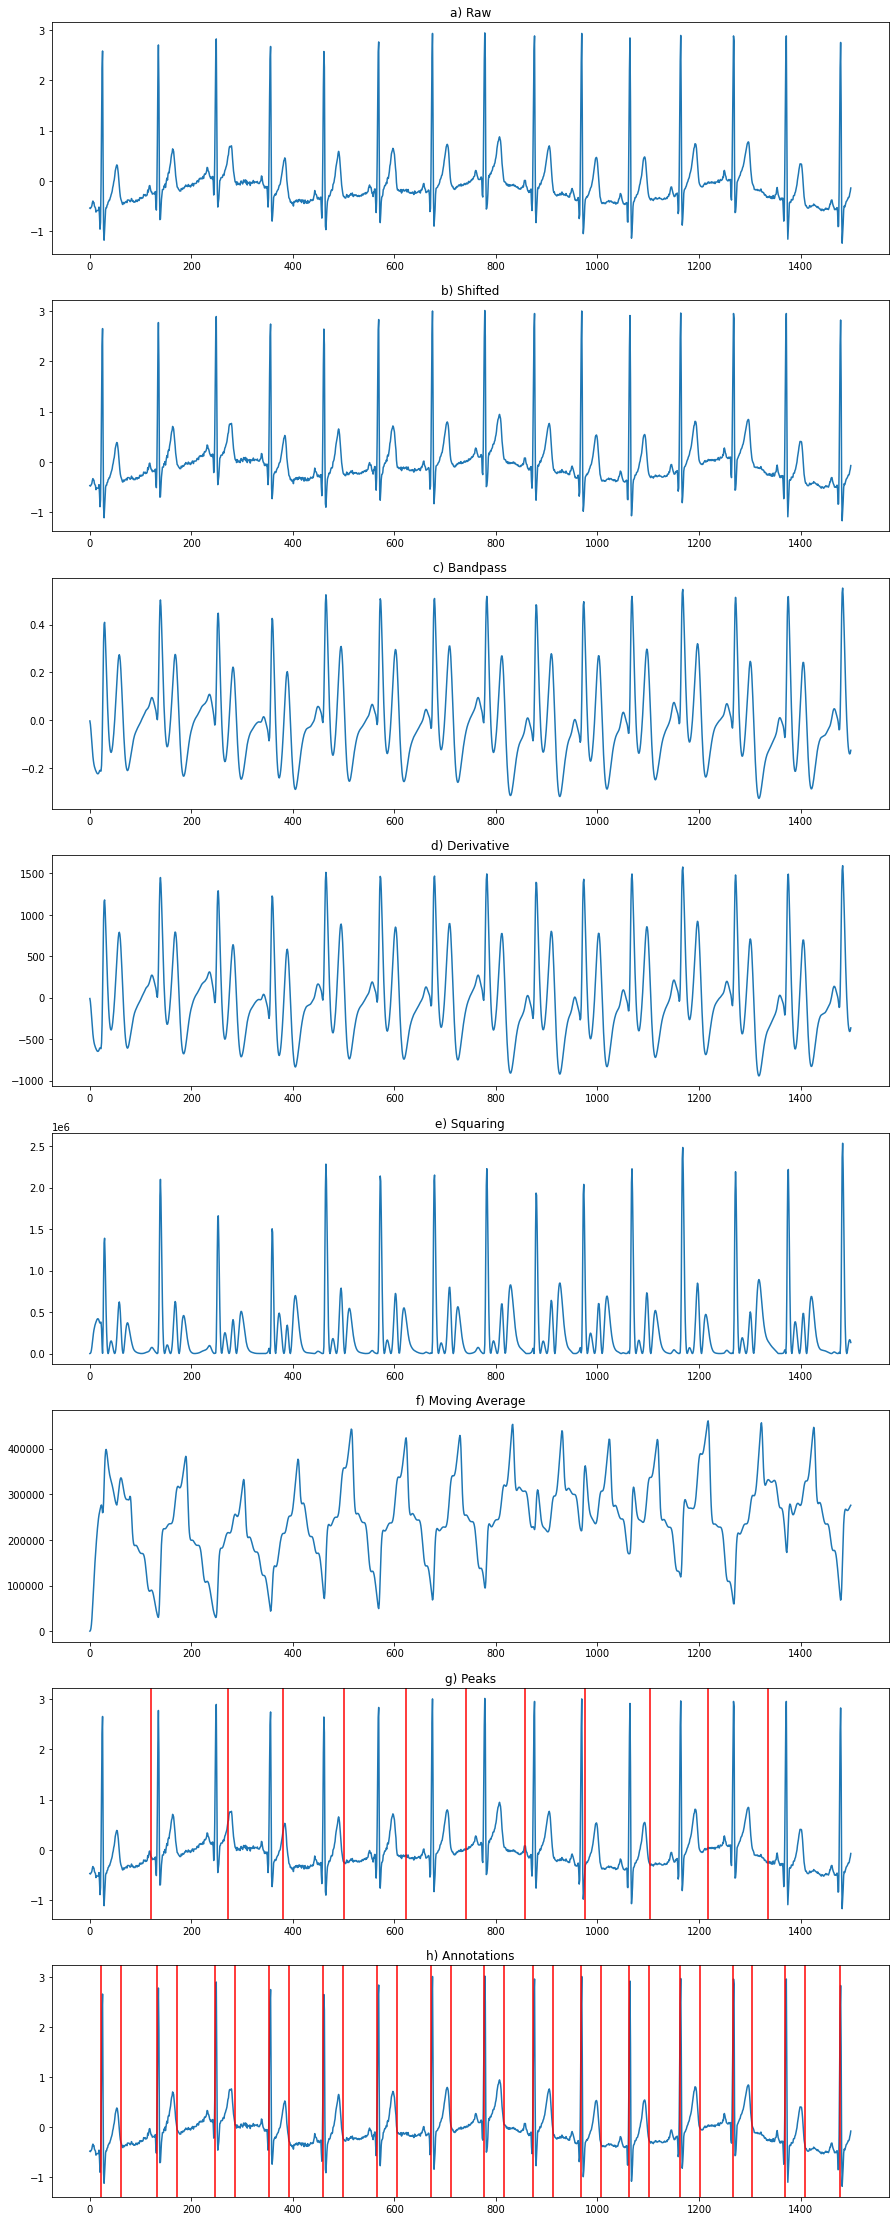

In [72]:
spath = '/content/physionet.org/files/nsrdb/1.0.0/16773'
print('Clean Signal')
peaks, real_peaks = run_pantompkins(spath, 'ECG1', 5, 11, 360, 11000, 12500)
evaluation(peaks, real_peaks-11000, int(150/(1000/128)))

## Hamilton-Tompkins

In [ ]:
import pip

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
from scipy import signal, ndimage

def hamilton_detector(unfiltered_ecg, sampling_freq):

    filtered_ecg = bandpass_ecg(unfiltered_ecg, 5, 11, sampling_freq)
    diff = differentiated_ecg(unfiltered_ecg, sampling_freq)
    averaged = time_averaged_ecg(unfiltered_ecg, sampling_freq)
    
    n_pks = []
    n_pks_ave = 0.0
    s_pks = []
    s_pks_ave = 0.0
    QRS = [0]
    RR = []
    RR_ave = 0.0

    th = 0.0

    i=0
    idx = []
    peaks = []  

    for i in range(1, len(averaged)-1):

        if averaged[i-1]<averaged[i] and averaged[i+1]<averaged[i]:
            peak = i
            peaks.append(i)

            if averaged[peak] > th and (peak-QRS[-1])>0.3*sampling_freq:        
                QRS.append(peak)
                idx.append(i)
                s_pks.append(averaged[peak])
                if len(n_pks)>8:
                    s_pks.pop(0)
                s_pks_ave = np.mean(s_pks)

                if RR_ave != 0.0:
                    if QRS[-1]-QRS[-2] > 1.5*RR_ave:
                        missed_peaks = peaks[QRS[-1]:QRS[-2]]
                        for missed_peak in missed_peaks:
                            if averaged[missed_peak]>0.3*th:
                                if (missed_peak-peaks[QRS[-2]]< 0.2*sampling_freq and missed_peak-peaks[QRS[-2]] >0.36*sampling_freq) or diff[missed_peak] > 0.5*diff[QRS[-2]]:
                                    QRS.append(missed_peak)
                                    QRS.sort()
                                    break

                if len(QRS)>2:
                    RR.append(QRS[-1]-QRS[-2])
                    if len(RR)>8:
                        RR.pop(0)
                    RR_ave = int(np.median(RR))

            else:
                n_pks.append(averaged[peak])
                if len(n_pks)>8:
                    n_pks.pop(0)
                n_pks_ave = np.mean(n_pks)

            th = n_pks_ave + 0.189*(n_pks_ave-s_pks_ave)


    QRS.pop(0)

    return QRS

def differentiated_ecg(input_signal, sampling_freq):
    diff_signal = input_signal.copy()
    for i in range(len(input_signal)):
        current_sample = 2*input_signal[i]

        if i>=1: current_sample += input_signal[i]
        if i>=3: current_sample -= input_signal[i-3]
        if i>=4: current_sample -= 2*input_signal[i-4]

        diff_signal[i] = current_sample / (8*sampling_freq)
    return diff_signal 

def bandpass_ecg(input_signal, low, high, sampling_freq):
    return high_pass_scipy_butterworth(low_pass_scipy_butterworth(input_signal, high, sampling_freq), low, sampling_freq)

def time_averaged_ecg(input_signal, sampling_freq):
    filtered = bandpass_ecg(input_signal, 5, 11, sampling_freq)
    diffed = differentiated_ecg(filtered, sampling_freq)
    squared = np.square(diffed)
    averaged = avg_ecg(squared, sampling_freq)
    return averaged

def avg_ecg(input_signal, sampling_freq):
    window_size = 32
    input_signal = input_signal.copy()
    moving_avg =  input_signal.copy()
    for index in range(len(input_signal)):
        if index < int(window_size/2) and len(input_signal)-index<int(window_size/2):
            continue
        else:
            moving_avg[index] = np.sum(input_signal[index-(int(window_size/2)-1): index+int(window_size/2)+1])
    moving_avg /= window_size
    moving_avg[0: window_size] = 0
    return moving_avg

def low_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(2, cutoff_freq/(sampling_freq/2), 'low', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

def high_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(1, cutoff_freq/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal


In [ ]:
def get_data(datapath, leads, start_samp, end_samp):
    signal, fields = wfdb.rdsamp(datapath, sampfrom=start_samp, sampto=end_samp, 
                                channel_names = leads)
    annots = wfdb.rdann(datapath, 'atr', sampfrom=start_samp, sampto=end_samp)

    return signal, annots.sample

In [ ]:
def wfdb_display_from_path(file_path, leads, start_samp, end_samp):
    record = wfdb.rdrecord(file_path, sampfrom=start_samp, sampto=end_samp, channels= leads)
    figure_title = os.path.basename(file_path)
    wfdb.plot_wfdb(record=record, title=figure_title)

def np_display(samples):
    plt.plot(samples)

def np_mark_peaks(plt, samples, peaks, title):
    plt.plot(samples)
    for peak in peaks:
        plt.axvline(x = peak, color = 'r')
    plt.title.set_text(title)

def compare_plot(signal1, signal2):
    plt.plot(signal1)
    plt.plot(signal2, color = 'r')
    plt.show()

In [ ]:
def evaluation(peaks, real_peaks, interval):
    check_peaks = real_peaks[1:]
    n_ref = len(check_peaks)
    n_detected = len(peaks)
    count = 0
    checked_ind = 0
    for i in range(n_detected):
      det_peak = peaks[i]
      for j in range(checked_ind, n_ref):
          correct = check_peaks[j]
          if det_peak > correct -interval and det_peak < correct +interval:
              count +=1
              checked_ind += 1
              break

    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": sensitivity*100,
              'PPV': ppv*100,
              'F1': f1*100
              }
    return result

## Test

In [ ]:
example_path = '/content/physionet.org/files/mitdb/1.0.0/105'
leads = ['V1']
fs=128

n_samples = 30*60*fs
raw_samples, real_peaks= get_data(example_path, leads, 0, 2000)

det_peaks = hamilton_detector(raw_samples, fs)
evaluation(det_peaks, real_peaks, 150*(1000/128))

{'sensitivity': 100.0, 'PPV': 16.666666666666664, 'F1': 28.57142857142857}

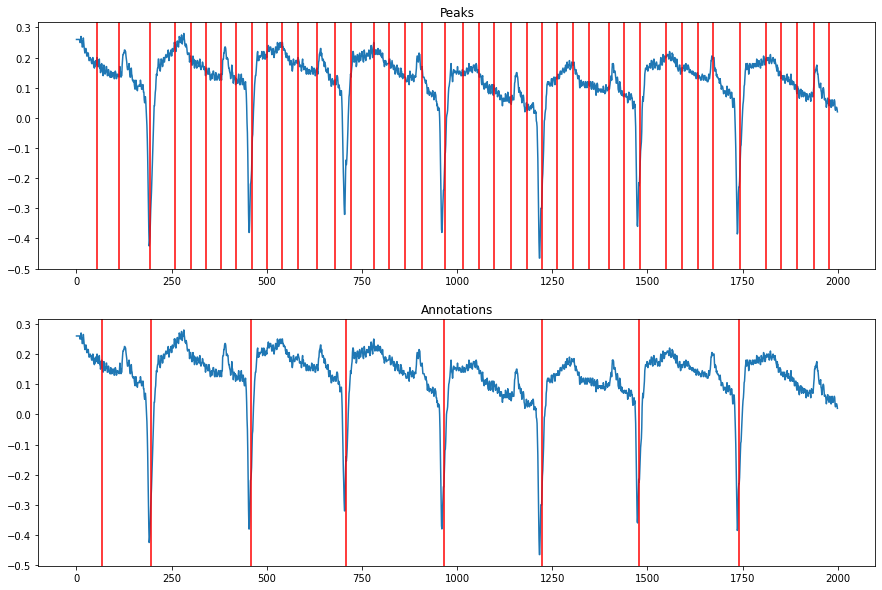

In [ ]:
fig, axs = plt.subplots(2, figsize=(15, 10))
np_mark_peaks(axs[0], raw_samples, det_peaks, 'Peaks')
np_mark_peaks(axs[1], raw_samples, real_peaks, 'Annotations')